# File Creater for the TOLIMAN Pupil

Install necessary packages

In [66]:
%pip install numpy-stl -q

Note: you may need to restart the kernel to use updated packages.


In [67]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import jax.numpy as np

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import OpticsSupport
import PlottingSupport

In [68]:
psf_flag = True

## Parameters

In [69]:
# Aperture parameters
ratio = 1                           # Ratio to scale the aperture by (e.g. 5 = 5-inch aperture becomes 1-inch aperture)
aperture_npix = 2000                # Number of pixels across the aperture
aperture_diameter = 0.125/ratio     # Clear aperture diameter (m)
secondary_diameter = 0.032/ratio    # Secondary mirror diameter (m)
spider_width       = 0.002/ratio    # Spider width (m)

# Observations wavelegths (bandpass of 530-640nm)
wavelengths = np.linspace(530e-9, 640e-9, 100)  # Wavelengths to simulate (m)

# Subtrate parameters
n1 = 1          # Refractive index of free space
n2 = 1.5424     # Refractive index of Zerodur

# Mask
mask_path = 'diffractive_pupil.npy'
phase_mask = np.load(mask_path) * np.pi     # Load the mask and convert to phase

# Grating parameters
amplitude = 375e-9                          # Amplitude of the grating (m). Peak to peak amplitude of the grating etched in the glass
det_npixels = 2048                          # DO NOT TOUCH
pixel_scale = dlu.arcsec2rad(0.375)*ratio   # 0.375 arcsec per pixel
max_reach = 0.8                             # Max wavelength to diffract to 80% of the diagonal length of the detector

## Create the mask

In [70]:
# Make the mask
mask, raw_mask, X, Y = OpticsSupport.HelperFunctions.make_grating_mask(phase_mask, aperture_npix, aperture_diameter, secondary_diameter, spider_width, wavelengths, amplitude, det_npixels, pixel_scale, max_reach, n1, n2, out = 0., apply_spiders=False, return_raw=True)

Grating amplitude: 4.8617119789123535
Nyquist Ratio: 2.4308559894561768
Grating period: 0.000303856999380514m


Plot mask to check correct pattern and resolution

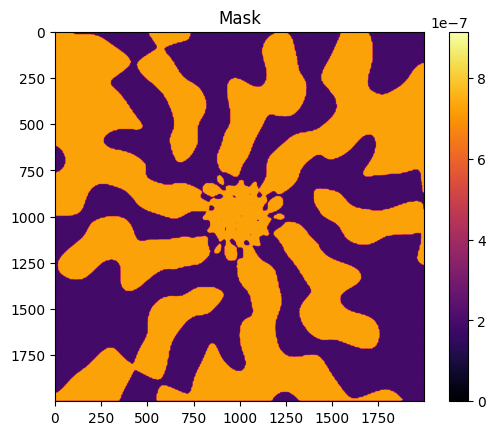

In [71]:
PlottingSupport.Plotting.printColormap(mask, title="Mask", colorbar=True, colormap="inferno")

Create the phase mask and the instrument

In [72]:
wf_npixels = aperture_npix                                  # Number of pixels across the wavefront
peak_wavelength = np.mean(wavelengths)                      # Peak wavelength of the bandpass (m)

# Create Telescope
phase_mask = OpticsSupport.HelperFunctions.createPhaseMask(raw_mask, peak_wavelength, n1, n2)  # Create the phase mask
mask = dl.Optic(phase=phase_mask)
optics = dlT.TolimanOpticalSystem(wf_npixels=wf_npixels, mask=mask, psf_npixels=det_npixels, oversample=1)
source = dlT.AlphaCen(n_wavels=100, separation=8, position_angle=30)
instrument = OpticsSupport.HelperFunctions.createTolimanTelescope(optics, source, ratio)


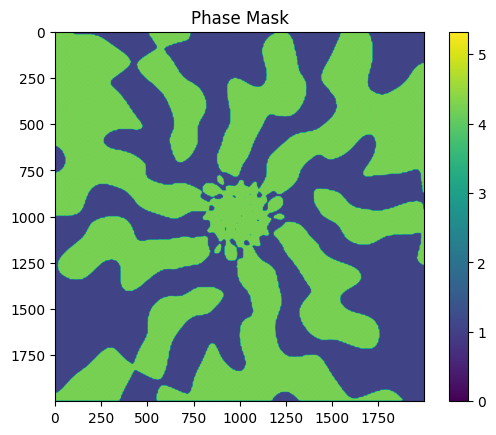

In [73]:
PlottingSupport.Plotting.printColormap(phase_mask, title="Phase Mask", colorbar=True)

Simulate the PSF

In [74]:
# Create PSF
if psf_flag:
    psf = instrument.model()

Display the PSF

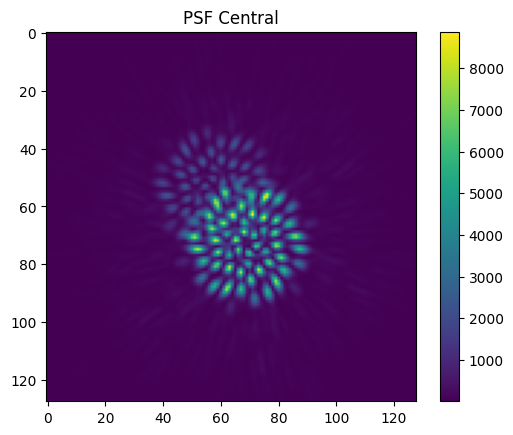

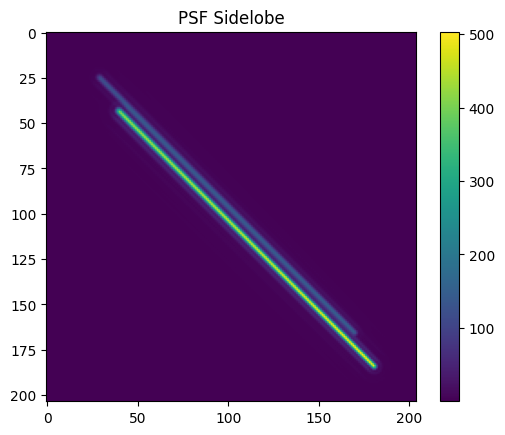

In [75]:
if psf_flag:
    r = psf.shape[0]
    c = r//2
    s = 64

    central_psf = psf[c-s:c+s, c-s:c+s]
    sidelobe_psf = psf[r//12:r//12+r//10,r//12:r//12+r//10]
    PlottingSupport.Plotting.printColormap(central_psf, title="PSF Central", colorbar=True)
    PlottingSupport.Plotting.printColormap(sidelobe_psf, title="PSF Sidelobe", colorbar=True)

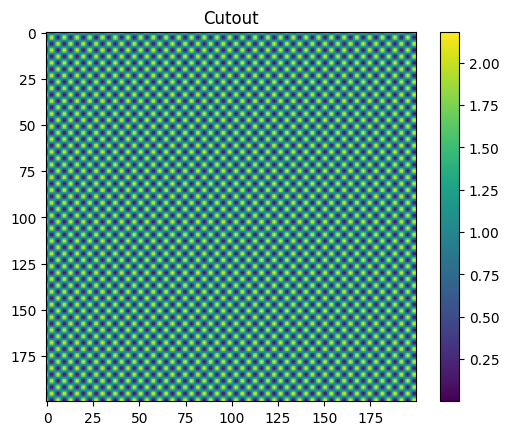

0.34758446
2.1839375
0.00014909999
2.1840866


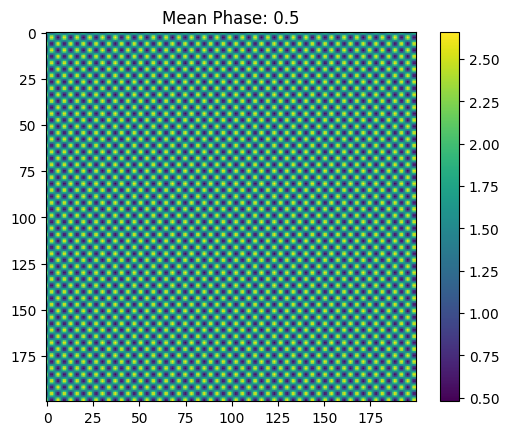

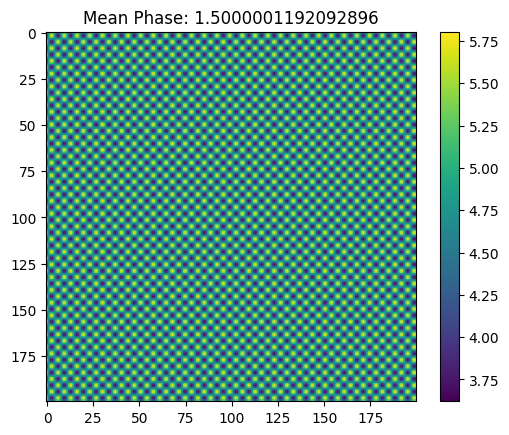

In [91]:
x_min = int((0/5)*aperture_npix)
x_max = int((0.5/5)*aperture_npix)
y_low_min = int((3.6/5)*aperture_npix)
y_low_max = int((4.1/5)*aperture_npix)
y_high_min = int((0.5/5)*aperture_npix)
y_high_max = int((1/5)*aperture_npix)

cutout = phase_mask[y_low_min:y_low_max,x_min:x_max]
PlottingSupport.Plotting.printColormap(cutout, title="Cutout", colorbar=True)
print((cutout.max()- cutout.min())/(2*np.pi))
print(cutout.max()- cutout.min())
print(cutout.min())
print(cutout.max())


cutout_mean = np.mean(cutout)
elevation = (0.5*np.pi - cutout_mean)
phase_mask_elevated = phase_mask + elevation

low_cutout_elevated = phase_mask_elevated[y_low_min:y_low_max,x_min:x_max]
PlottingSupport.Plotting.printColormap(low_cutout_elevated, title=f"Mean Phase: {round(np.mean(low_cutout_elevated)/np.pi,3)}", colorbar=True)

high_cutout_elevated = phase_mask_elevated[y_high_min:y_high_max,x_min:x_max]
PlottingSupport.Plotting.printColormap(high_cutout_elevated, title=f"Mean Phase: {round(np.mean(high_cutout_elevated)/np.pi,3)}", colorbar=True)


Calculate phase amplitude

In [77]:
p2p = (low_cutout_elevated.max()- low_cutout_elevated.min())/(2*np.pi)
print(p2p)

0.34757838


In [78]:
# central = psf[c-s:c+s, c-s:c+s]
# #plt.title(psf[c-s:c+s, c-s:c+s].sum())
# plt.imshow(central)
# plt.savefig('psf_center.png',dpi=500)
# plt.colorbar()
# plt.show()

In [79]:
# plt.title(psf.sum())
# #plt.imshow(psf**0.1)
# plt.imshow(psf**0.2, cmap='inferno')
# plt.colorbar()
# plt.savefig("full_psf.png")
# plt.show()
# print(amplitude)
# print(central.sum()/psf.sum())

In [80]:
# psf[150:400, 150:400].sum()*100

In [81]:
# side_lobe = psf[150:400, 150:400]

# plt.title(side_lobe.sum())
# plt.imshow(side_lobe, cmap='inferno')
# plt.colorbar()
# plt.savefig("sidelobe.png")
# plt.show()
# print(side_lobe.sum()/psf.sum())    

In [82]:
optics

TolimanOpticalSystem(
  wf_npixels=2000,
  diameter=0.125,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[2000,2000], normalise=True),
    'pupil':
    Optic(opd=None, phase=f32[2000,2000], transmission=None, normalise=False)
  },
  psf_npixels=2048,
  oversample=1,
  psf_pixel_scale=0.375
)

Cut out the circular parts

In [83]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [84]:
def create_circular_cutout(diameter_ratio, centre, aperture_npix):
    radius = aperture_npix * diameter_ratio / 2
    mask = create_circular_mask(aperture_npix, aperture_npix, center=centre, radius=radius)
    return mask

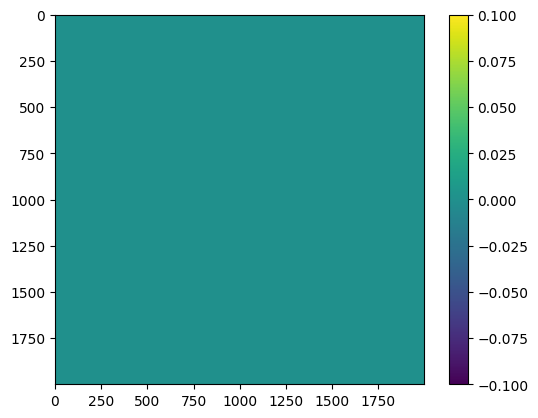

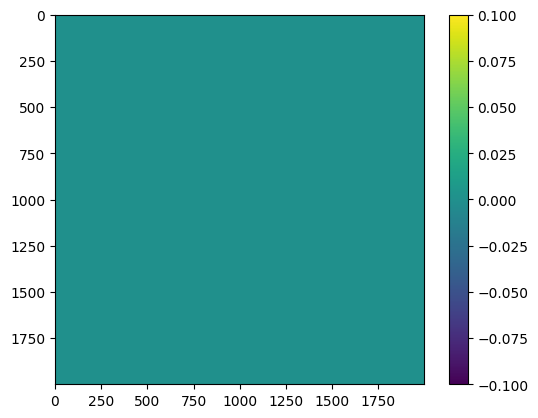

/var/folders/4b/044yrk2x623bdjnxpbg9649r0000gn/T/ipykernel_35964/1023766165.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(zoom,cmap="viridis")
/var/folders/4b/044yrk2x623bdjnxpbg9649r0000gn/T/ipykernel_35964/1023766165.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(zoom,cmap="viridis")


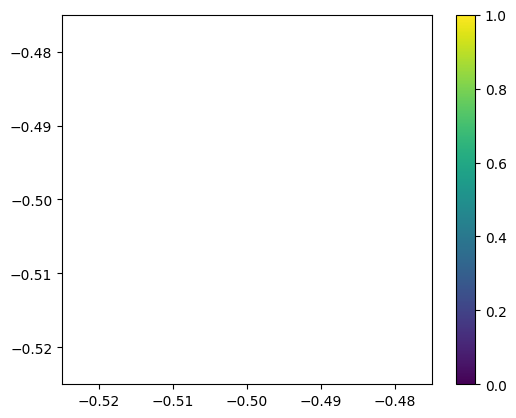

SystemError: tile cannot extend outside image

In [85]:
inch_cutout = create_circular_cutout(0.2, (4000,2600), aperture_npix)
plt.imshow(inch_cutout)
plt.colorbar()
plt.show()

inch_cutout_elevated_phase_mask = (phase_mask+elevation) * inch_cutout
plt.imshow(inch_cutout_elevated_phase_mask,cmap="viridis")
plt.colorbar()
plt.show()


radius = int(aperture_npix * 0.2 / 2)
zoom = inch_cutout_elevated_phase_mask[(2600-radius):(2600+radius),(4000-radius):(4000+radius)]
plt.imshow(zoom,cmap="viridis")
plt.colorbar()
plt.show()

plt.imsave('inch_cutout.png', zoom)
np.save('inch_cutout.npy', zoom)

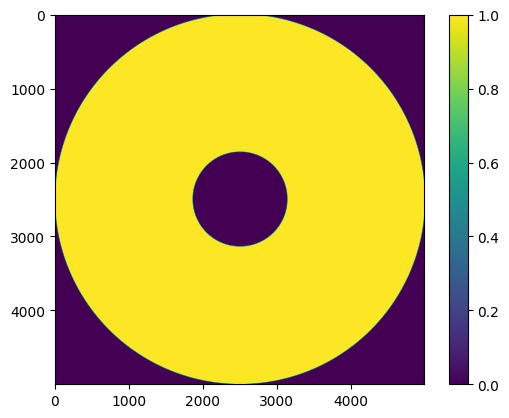

In [ ]:
circular_mask_outer = create_circular_mask(aperture_npix,aperture_npix, radius=aperture_npix/2)
inner_r = (aperture_npix*(secondary_diameter/aperture_diameter))/2
circular_mask_inner = 1 - create_circular_mask(aperture_npix,aperture_npix, radius=inner_r)
circular_mask = circular_mask_outer & circular_mask_inner
plt.imshow(circular_mask)
plt.colorbar()
plt.show()

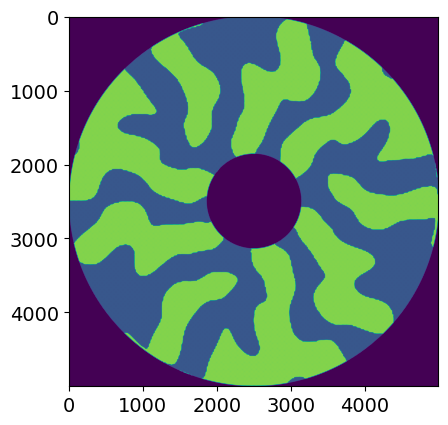

In [ ]:
circular_elevated_phase_mask = (phase_mask+elevation) * circular_mask
#print(circular_elevated_phase_mask)

plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#000000','#02bde4'])

plt.imshow(circular_elevated_phase_mask,cmap="viridis")
# ticks = np.linspace(0,4096,3)
# ticklabels_x = np.linspace(-63,63,3)
# ticklabels_y = np.linspace(63,-63,3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticklabels_x)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticklabels_y)
# plt.xlabel('x (pixels)')
# plt.ylabel('y (pixels)')
# plt.colorbar(label = 'Phase (rad)')
plt.imsave('full_diffractive_pupil.png', circular_elevated_phase_mask)
plt.show()

Convert the mask to a bitmap (adding to make mean pi)

In [ ]:
np.save('new_diffractive_pupil.npy', circular_elevated_phase_mask)

TypeError: Image data of dtype object cannot be converted to float

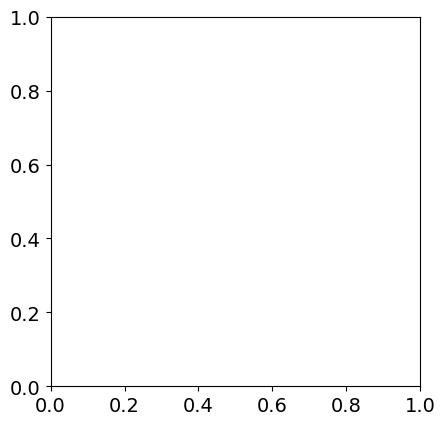

In [ ]:
plt.imshow(mask)
plt.colorbar()

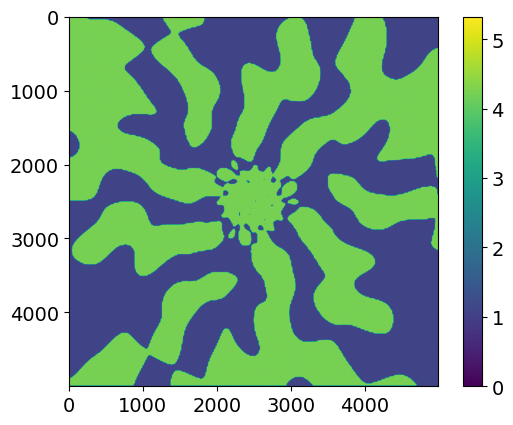

In [ ]:
plt.imshow(phase_mask)
plt.colorbar()

In [ ]:
period = calculate_grating_period(max_reach, pixel_scale, det_npixels, wavelengths, aperture_diameter, aperture_npix)
print(period)

Grating amplitude: 12.154280662536621
Nyquist Ratio: 6.0771403312683105
0.000303857


TypeError: Image data of dtype object cannot be converted to float

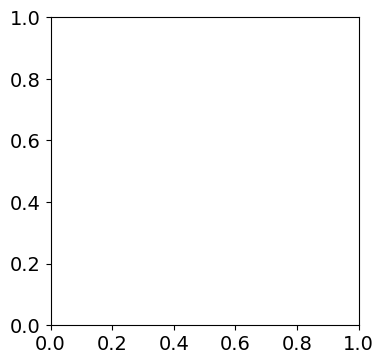

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask)
# plt.imshow(raw_mask)
plt.colorbar()

plt.subplot(1, 2, 2)
s0 = 1500
s1 = s0 + 100
plt.imshow(mask[s0:s1, s0:s1])
# plt.imshow(raw_mask[s0:s1, s0:s1])
plt.colorbar()
plt.show()

In [ ]:
# !pip install dLuxToliman -q

In [ ]:
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
large_mask = mask * 1e3
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
large_mask = mask * 1e6
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
import dLux
class ApplyMask(dLux.optics.OpticalLayer):
    depth : np.ndarray
    n : np.ndarray

    def __init__(self, depth, n):
        super().__init__(name='ApplyMask')
        self.depth = np.asarray(depth, float)
        self.n = np.asarray(n, float)
    
    def __call__(self, wavefront):
        opd = self.depth * self.n
        return wavefront.add_opd(opd)

In [ ]:
# Primary and secondary parameters
wf_npix = aperture_npix
layers = [dl.CreateWavefront(wf_npix, aperture_diameter, 'Angular')]

# Aperture parameters
secondary_ratio = secondary_diameter/aperture_diameter
spider_ratio    = spider_width/aperture_diameter
aperture = dl.ApertureFactory(wf_npix, 
                             secondary_ratio=secondary_ratio, 
                             nstruts=3, 
                             strut_rotation=-np.pi/2, 
                             strut_ratio=spider_ratio)
layers.append(aperture)
layers.append(dl.NormaliseWavefront())

# # Mask
# layers.append(dl.AddOPD(mask))

# # CLIMB mask
# seed = 0
# mask_basis = np.load("optimisation_params/basis.npy")
# mask_coeffs = jr.normal(jr.PRNGKey(seed), (mask_basis.shape[0],))
# mask = dl.ApplyBasisCLIMB(mask_basis, spec_wavelengths.mean(), mask_coeffs)
# layers.append(mask)
layers.append(ApplyMask(mask, n2))

# # Aberrations layer
# zernike_basis = 1e-9*dl.SimpleAperture(wf_npix, zernikes=np.arange(4, 11)).basis
# aberrations = dl.ApplyBasisOPD(zernike_basis)
# layers.append(aberrations)

# Propagator
# det_npix = 200
oversample = 1
# pixelscale = arcsec_to_rad(0.375)
propagator = dl.AngularMFT(oversample*det_npixels, pixel_scale/oversample, 
                           pixel_shift=True)
layers.append(propagator)

# Optics and telescope
optics = dl.Optics(layers)

In [ ]:
optics.summarise()

In [ ]:
full_wavels = np.linspace(545e-9, 645e-9, 100)

source = dl.PointSource(wavelengths=full_wavels)
psf = optics.model(source=source)

In [ ]:
psf.sum()

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Full Chip")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Full Chip sqrt scale")
plt.imshow(psf**0.5)
plt.colorbar()
plt.savefig("full_chip")

In [ ]:
# Central region
c = psf.shape[0]//2
s = 100

cen = psf[c-s:c+s, c-s:c+s]

# Corners
s0 = 170
s1 = s0 + 200

corn1 = psf[s0:s1, s0:s1] # Top left
corn2 = psf[s0:s1, -s1:-s0] # Top right
corn3 = psf[-s1:-s0, s0:s1] # Bottom left
corn4 = psf[-s1:-s0, -s1:-s0] # Bottom right
corns = [corn1, corn2, corn3, corn4]

s = 1e3
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 5)
plt.title(f"{cen.sum()*100:.2f}% total flux")
plt.imshow(cen*s)
plt.colorbar()

indexes = [1, 3, 7, 9]
for i in range(len(corns)):
    plt.subplot(3, 3, indexes[i])
    plt.title(f"{corns[i].sum()*100:.2f}% total flux")
    plt.imshow(corns[i]*s)
    plt.colorbar()

plt.savefig("transmissive_mask.png")

In [ ]:
print(np.array(corns).sum())

In [ ]:
psf.sum()

In [ ]:
import pathlib

In [ ]:
pathlib.Path

In [ ]:
import os

print(os.getcwd())
p = pathlib.Path("test")

In [ ]:
isinstance(p, pathlib.Path)

In [ ]:
str(p)

In [ ]:
import zodiax as zdx
from jax import numpy as np, scipy as scp


# A simple class to model 1d normals
class Normal(zdx.Base):
    mean      : np.ndarray
    scale     : np.ndarray
    amplitude : np.ndarray

    def __init__(self, mean, scale, amplitude):
        self.mean      = np.asarray(mean,      dtype=float)
        self.scale     = np.asarray(scale,     dtype=float)
        self.amplitude = np.asarray(amplitude, dtype=float)
    
    def model(self, width=10):
        xs = np.linspace(-width, width, 128)
        return self.amplitude * scp.stats.norm.pdf(xs, self.mean, self.scale)


# A class to store and model a set of normals
class NormalSet(zdx.Base):
    normals : dict
    width   : np.ndarray

    def __init__(self, means, scales, amplitude, names, width=10):
        normals = {}
        for i in range(len(names)):
            normals[names[i]] = Normal(means[i], scales[i], amplitude[i])
        self.normals = normals
        self.width = np.asarray(width, dtype=float)
    
    def __getattr__(self, key):
        if key in self.normals.keys():
            return self.normals[key]
        else:
            raise AttributeError(f"{key} not in {self.normals.keys()}")
    
    def model(self):
        return np.array([normal.model(self.width) 
            for normal in self.normals.values()]).sum(0)

sources = NormalSet([-1., 2.], [1., 2.], [2., 4.], ['alpha', 'beta'])

In [ ]:
zdx.experimental.serialise(p, sources)